# Jr. Data Scientist Assesment for UMortgage
 Halle Purdom
 01/13/23


In [1]:
# Mounting Google Collab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Data Preparation and Exploration

In [3]:
# Data import
# train = pd.read_csv(r"C:\Users\Halle\Documents\Job Search\Jr._Data_Scientist_Assessment (1)\Jr. Data Scientist Assessment\train.csv")
# test = pd.read_csv(r"C:\Users\Halle\Documents\Job Search\Jr._Data_Scientist_Assessment (1)\Jr. Data Scientist Assessment\test.csv")

# For Google Collab (tensorflow)
train = pd.read_csv("/content/drive/MyDrive/Job Search/UMortgage/train.csv")


train.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# Data Shape - 13 features, 367 rows
print("Data Shape: ", train.shape)

Data Shape:  (614, 13)


In [5]:
# Data Columns
print("Columns: ")
train.dtypes

Columns: 


Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Male      489
Female    112
Name: Gender, dtype: int64


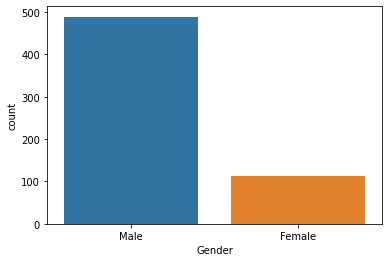

Yes    398
No     213
Name: Married, dtype: int64


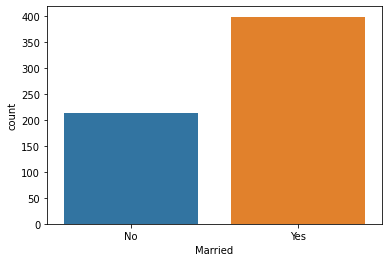

Graduate        480
Not Graduate    134
Name: Education, dtype: int64


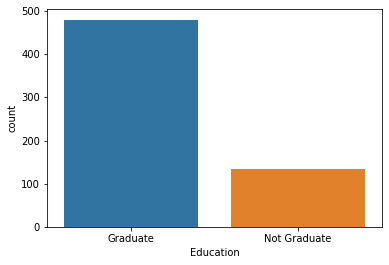

No     500
Yes     82
Name: Self_Employed, dtype: int64


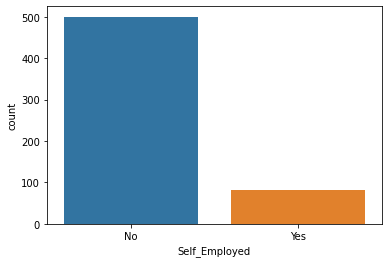

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


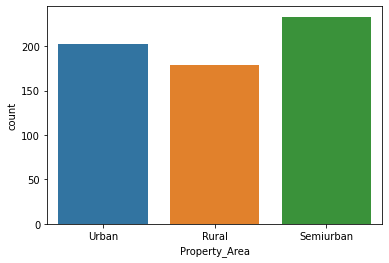

In [6]:
# Object Variable Distribution
obj_vars = ['Gender', 'Married', 'Education', 'Self_Employed','Property_Area']
for i in obj_vars:
    print(train[i].value_counts())
    sns.countplot(x=train[i], data= train)
    plt.show()


0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


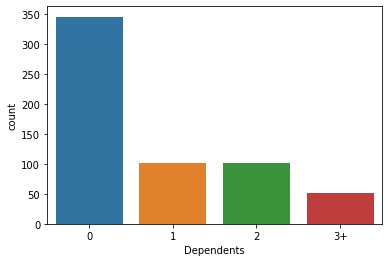

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64


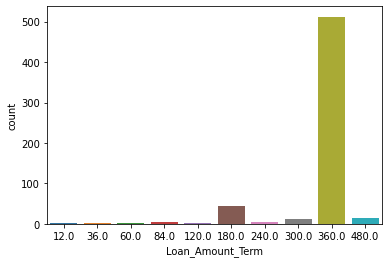

1.0    475
0.0     89
Name: Credit_History, dtype: int64


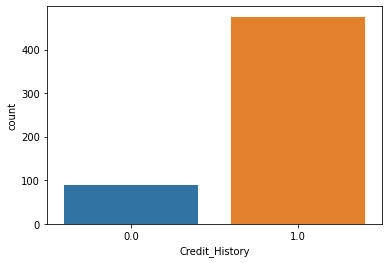

In [7]:
# Ordinal Variable Distribution
ord_vars = ['Dependents', 'Loan_Amount_Term', 'Credit_History']
for i in ord_vars:
    print(train[i].value_counts())
    sns.countplot(x=train[i], data= train)
    plt.show()

Applicant Income: 


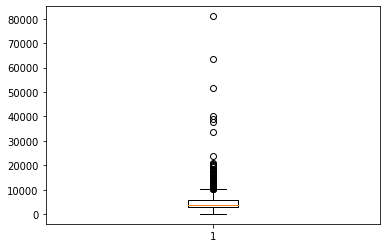

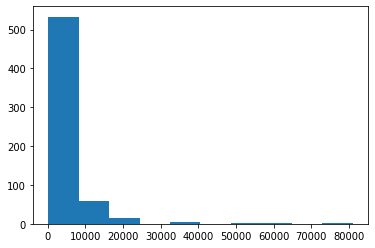

Coapplicant Income: 


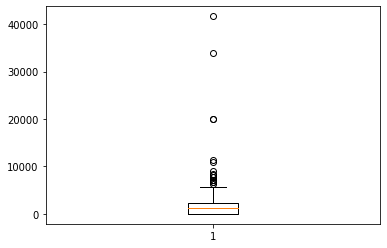

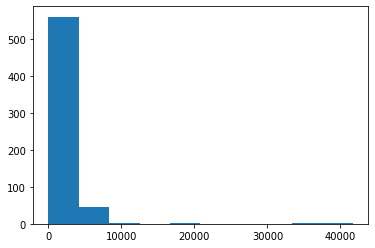

Loan Amount: 


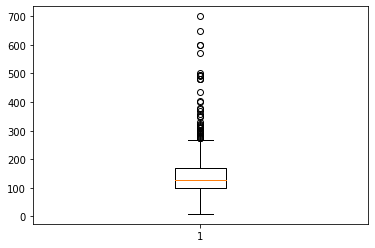

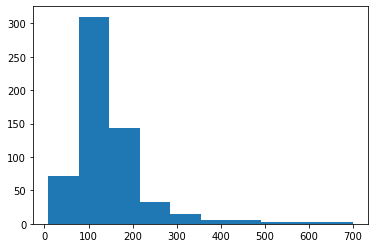

In [8]:
# Numeric Variable Distribution

# Applicant Income
print("Applicant Income: ")
plt.boxplot(train['ApplicantIncome'])
plt.show()

plt.hist(train['ApplicantIncome'])
plt.show()

# Coapplicant Income
print("Coapplicant Income: ")

plt.boxplot(train['CoapplicantIncome'])
plt.show()

plt.hist(train['CoapplicantIncome'])
plt.show()

# Loan Amount - Missing Values
train_LoanAmnt = train['LoanAmount'].dropna()

print("Loan Amount: ")
plt.boxplot(train_LoanAmnt)
plt.show()

plt.hist(train_LoanAmnt)
plt.show()

Y    422
N    192
Name: Loan_Status, dtype: int64


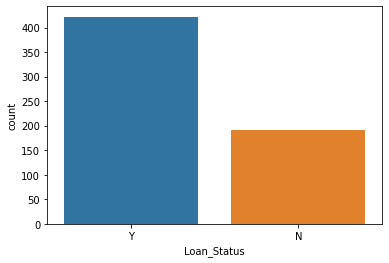

In [9]:
# Binary Target Distrubition - Loan Status
print(train['Loan_Status'].value_counts())
sns.countplot(x='Loan_Status', data= train)

In [10]:
# Checking for Duplicates
print(train.duplicated().sum())

0


In [11]:
# Checking for Missing Values
missing = (train.isnull().sum())
percent_missing = (train.isnull().sum()/len(train)*100)
miss_table = pd.concat([missing, percent_missing], axis = 1)
miss_table.columns = (['missing', 'percent_missing'])
print(miss_table)



                   missing  percent_missing
Loan_ID                  0         0.000000
Gender                  13         2.117264
Married                  3         0.488599
Dependents              15         2.442997
Education                0         0.000000
Self_Employed           32         5.211726
ApplicantIncome          0         0.000000
CoapplicantIncome        0         0.000000
LoanAmount              22         3.583062
Loan_Amount_Term        14         2.280130
Credit_History          50         8.143322
Property_Area            0         0.000000
Loan_Status              0         0.000000


In [12]:
# Missing Value Imputation

# I will use a less complex imputation method
# There is not too much missing data
# Since time is limited, time/resources would be better spent with the final model tuning

# Categorical -- Mode? New Cateogory? How much does this upset the distribution? 

# Gender - Mode
# Married - Mode
# Dependents - Mode
# Self Employed - Mode
# Loan Amount - Median (Not Mean because of skew)
# Loan Amount Term - Mode
# Credit History - Separate Category


# Dataset 1: Imputation - all less than 10%
train_impute = train.copy()

# Mode
train_impute['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train_impute['Married'].fillna(train['Married'].mode()[0], inplace=True)
train_impute['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train_impute['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

# New Category - Missing
train_impute['Self_Employed'].fillna('Missing', inplace=True)
train_impute['Credit_History'].fillna('Missing', inplace=True)

# Median
train_impute['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

# Dataset 2: Throwing Out Missing Rows 
train_drop = train.dropna(how='any')

# Check if missing values are gone in both datasets
print(train.isnull().sum())
print(train_impute.isnull().sum())
print(train_drop.isnull().sum())
print(train_drop.shape)


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
(480, 13)


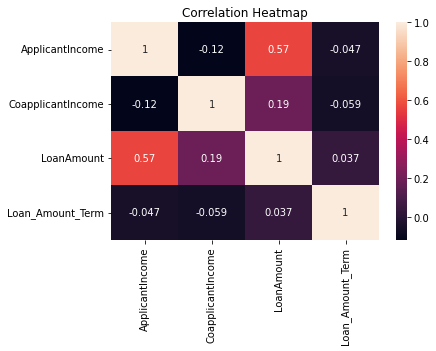

In [13]:
# Checking Numeric Correlations (After Imputation)
heatmap = sns.heatmap(train_impute.corr(), annot=True)
heatmap.set_title("Correlation Heatmap")
plt.show()

# Note: Credit History is binary, Loan Amount is in set buckets so main focus is on upper left corner 9x9 of heatmap

Strong correlation between Loan Amount and Application Income. This violates the multicollinearity requirement of logistic regression. 

In [14]:
# Changing Column Types
train_revise = train_impute.copy()

train_revise = train_revise.drop("Loan_ID", axis=1) # Dropping because only unique values per row

train_revise['ApplicantIncome'] = train_revise['ApplicantIncome'].astype('float') # Make consistent with other numeric variables

# train_revise['Loan_Amount_Term'] = train_revise['Loan_Amount_Term'].astype('object')
train_revise['Credit_History'] = train_revise['Credit_History'].astype('object')

train_revise.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History        object
Property_Area         object
Loan_Status           object
dtype: object

In [15]:
# Define Numeric and Categorical Columns
num_col = [i for i in train_revise.columns if train_revise.dtypes[i]=='float']
categ_col = [i for i in train_revise.columns if train_revise.dtypes[i]=='object']
categ_col.remove('Loan_Status')

print(num_col)
print(categ_col)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']


In [16]:
# Numeric Standardization

# Assigning mean and standard deviation to variables to standardize the testing set
mean_AppIncome_train = train_revise['ApplicantIncome'].mean()
std_AppIncome_train = train_revise['ApplicantIncome'].std()

mean_CoappIncome_train = train_revise['CoapplicantIncome'].mean()
std_CoappIncome_train = train_revise['CoapplicantIncome'].std()

mean_LoanAmnt_train = train_revise['LoanAmount'].mean()
std_LoanAmnt_train = train_revise['LoanAmount'].std()

mean_LAT_train = train_revise['Loan_Amount_Term'].mean()
std_LAT_train = train_revise['Loan_Amount_Term'].std()

train_revise['ApplicantIncome'] = (train_revise['ApplicantIncome']-mean_AppIncome_train)/std_AppIncome_train
train_revise['CoapplicantIncome'] = (train_revise['CoapplicantIncome']-mean_CoappIncome_train)/std_CoappIncome_train
train_revise['LoanAmount'] = (train_revise['LoanAmount']-mean_LoanAmnt_train)/std_LoanAmnt_train
train_revise['Loan_Amount_Term'] = (train_revise['Loan_Amount_Term']-mean_LAT_train)/std_LAT_train


numer_features = train_revise[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']]

In [17]:
# Categorical Variable One Hot Encoding
categ_features = pd.get_dummies(train_revise[categ_col])

In [18]:
# Recombine Categorical with Numeric
train_processed = pd.concat([numer_features, categ_features], axis=1)
train_processed.shape

(614, 23)

In [19]:
# Target into binary: YES=0 NO=1
target = pd.factorize(train_revise['Loan_Status'])

In [20]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(train_processed, target[0], test_size=0.2, random_state = 166, shuffle=True)

In [21]:
# Check train test split
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(491, 23)
(123, 23)
491
123


### Data Exploration:

Looking at the training data, there are 614 rows and 13 columns, including the target variable Loan Status. Of the 12 other variables, 3 are numeric and continuous. The distribution of each can be seen above in both boxplots and histograms. Each are largely right skewed. These columns were standardized, and the testing data was standardized based on the training set's means and standard deviations to ensure the transformation of the data remained consistent between train and test set. 

Some values initially appeared numeric, but fell into discrete buckets. These include Dependents, Credit History, and Loan Amount Term. Dependents and Credit History were treated as categorical as they had 4 and 2 possible values respectively. Loan Amount Term was tested both as a categorical and numeric continuous variable, since there were so many buckets present. However, this did not noticeably affect any of the models so the variable was kept numeric since some buckets existed in the training set but not the test set (and therefore produced different columns when one hot encoded in each set). 

Five columns were purely categorical and one hot encoded for analysis. Loan ID was dropped as it is unique to each row of data. The target variable, Loan Status, was converted from Yes/No to a binary. 

There was missing data scattered pretty randomly throughout both the training and test sets of data. For columns with less than 3% missing data, the mode (categorical) and median (numeric) was used to impute values. Self Employed and Credit History were 5 and 8 percent missing, so instead of mode I chose to create a separate category for the missing data as to not greatly disrupt the distribution of the categories in each column. I also tested both imputation and adding an additional missing category label, and found no noticeable difference in the model performance statistics. 

In the numeric variables, there was a pretty strong correlation between Loan Amount and Application Income. This violates the multicollinearity requirement of logistic regression, however in thinking about the use case of this model we are really prioritizing performance rather than if models violate any assumptions. With this in consideration I will still consider Logistic Regression models. 

# Model Creation

### Hypothesis: 

Based on the data, I expect a Random Forest model to perform best. Random Forest is sometimes treated as a baseline model, to be created initially for the performance statistics. Then usually more complex models are tested and try to outperform the Random Forest. This is why I expect an outperformance, and I will be testing the following models to see if this is the case and get the best predictions possible out of the data: 
1. Logistic Regression
2. Random Forest
3. XGBoost
4. SGD Classifier
5. Linear SVC
6. Dense Neural Network

## Logistic Regression

#### Basic Logistic Regression

In [22]:
# Basic Logistic Regression

lr_basic = LogisticRegression(max_iter = 1500)

lr_basic.fit(X_train, y_train)
cross_res = cross_val_score(lr_basic, X_train, y_train, scoring = 'accuracy')
print(cross_res)

[0.77777778 0.79591837 0.78571429 0.84693878 0.80612245]


In [23]:
# Evaluate final model with test data
y_pred_basic = lr_basic.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=y_pred_basic)
recall = recall_score(y_true=y_test, y_pred=y_pred_basic)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_basic)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2}")

Accuracy: 0.85
Precision: 0.93
Recall: 0.42


In [24]:
print(classification_report(y_test, y_pred_basic))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91        92
           1       0.93      0.42      0.58        31

    accuracy                           0.85       123
   macro avg       0.88      0.70      0.74       123
weighted avg       0.86      0.85      0.82       123



#### L1 Logistic Regression (Lasso)

In [25]:
# L1 Logistic Regression

l1_model = LogisticRegression(penalty='l1', solver = 'saga', max_iter = 1500)

split = KFold(n_splits = 5, shuffle = True)

l1_param_grid = {
    "C": np.random.uniform(low=0, high=20, size=1000)
}

L1_cv = RandomizedSearchCV(
    l1_model, l1_param_grid, n_iter=30, cv=split, n_jobs=-1, scoring='accuracy'
)

In [26]:
# Build model based on best parameters found above
feature_cols = X_train.columns
l1_model_best = LogisticRegression(penalty='l1', solver = 'saga', C=0.193, max_iter=1500)
l1_model_best.fit(X_train, y_train)

LogisticRegression(C=0.193, max_iter=1500, penalty='l1', solver='saga')

In [27]:
# Evaluate model with test data
y_pred_l1 = l1_model_best.predict(X_test)

In [28]:
precision = precision_score(y_true=y_test, y_pred=y_pred_l1)
recall = recall_score(y_true=y_test, y_pred=y_pred_l1)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_l1)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2}")

Accuracy: 0.85
Precision: 0.93
Recall: 0.42


In [29]:
print(classification_report(y_test, y_pred_l1))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91        92
           1       0.93      0.42      0.58        31

    accuracy                           0.85       123
   macro avg       0.88      0.70      0.74       123
weighted avg       0.86      0.85      0.82       123



#### L2 Logistic Regression (Ridge)

In [30]:
# L2 model tuning parameters
l2_model = LogisticRegression(penalty='l2',  max_iter = 1500)

split = KFold(n_splits = 5, shuffle = True)

l2_param_grid = {
    "C": np.random.uniform(low=0, high=20, size=1000)
}

L2_cv = RandomizedSearchCV(
    l2_model, l2_param_grid, n_iter=30, cv=split, n_jobs=-1, scoring='accuracy'
)

In [31]:
l2_model_best = LogisticRegression(penalty='l2', C=1.93, max_iter=1500,)
l2_model_best.fit(X_train, y_train)

LogisticRegression(C=1.93, max_iter=1500)

In [32]:
# Evaluate final model with test data
y_pred_l2 = l2_model_best.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=y_pred_l2)
recall = recall_score(y_true=y_test, y_pred=y_pred_l2)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_l2)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2}")

Accuracy: 0.85
Precision: 0.93
Recall: 0.42


In [33]:
print(classification_report(y_test, y_pred_l2))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91        92
           1       0.93      0.42      0.58        31

    accuracy                           0.85       123
   macro avg       0.88      0.70      0.74       123
weighted avg       0.86      0.85      0.82       123



## Random Forest

In [58]:
# Random Forest Parameter tuning
split = KFold(n_splits = 5, shuffle = True)

param_grid = {    
    'max_depth': [1, 2, 3, 6, 9,10, 15, 20, 25, 30 , 35], 
    'max_features': [10,15, 20, 25, 30, 35, 40],
    'min_samples_leaf': [3, 4, 5, 7, 9, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 14, 16, 20],
    'n_estimators': [100],
    'class_weight':['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = split, n_jobs = 6, verbose = 2, scoring='accuracy', n_iter=100)

In [59]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
290 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
290 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py"

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=6,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 6, 9, 10, 15, 20,
                                                      25, 30, 35],
                                        'max_features': [10, 15, 20, 25, 30, 35,
                                                         40],
                                        'min_samples_leaf': [3, 4, 5, 7, 9, 10,
                                                             15, 20],
                                        'min_samples_split': [8, 10, 12, 14, 16,
                                                              20],
                                     

In [60]:
# Best parameters
print(grid_search.best_estimator_)
print(grid_search.best_score_)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=1,
                       max_features=20, min_samples_leaf=5,
                       min_samples_split=8)
0.8004947433518863


In [61]:
# Add best params from above, make n_estimators greater=1000
rf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features=20, min_samples_leaf=15,
                       min_samples_split=12)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features=20, min_samples_leaf=15,
                       min_samples_split=12)

In [62]:
# Performance statistics
preds = rf.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=preds)
recall = recall_score(y_true=y_test, y_pred=preds)
accuracy = accuracy_score(y_true=y_test, y_pred=preds)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5}")

Accuracy: 0.84553
Precision: 0.92857
Recall: 0.41935


## XGBoost

In [34]:
# Create dmatrices for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtest,'eval'), (dtrain,'train')]
num_round = 1000

In [35]:
#Random search with xgboost package and dmatrices

params = {
    'booster':'gbtree',
    'objective':'multi:softmax',
    'num_class':2,
    'eta':0.05,
    'subsample':0.5,
    'colsample_bytree':0.5,
    'max_depth':3,
    'min_child_weight':1,
    'gamma': 0.5,
}

max_depth = [3,5,10,15,20,40]
sub_s = np.random.random(10)
cols = np.random.random(10)
md = np.random.randint(0,6,10)
m_child = [1, 5, 10]
mc = np.random.randint(0,3,10)
gam = [0.5, 1, 1.5, 2, 5]
g = np.random.randint(0,5,10)

for i in range(10):
    params['subsample']=sub_s[i]
    params['colsample_bytree']=cols[i]
    params['max_depth']=max_depth[md[i]]
    params['min_child_weight']=m_child[mc[i]]
    params['gamma']=gam[g[i]]
    tmp = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, stratified=False, metrics=(['mlogloss']), early_stopping_rounds=2)
    print('______________________done______________________')
    print(params)
    print(tmp.loc[tmp.shape[0]-1:,:])
    print("================================================")
    tmp=0

______________________done______________________
{'booster': 'gbtree', 'objective': 'multi:softmax', 'num_class': 2, 'eta': 0.05, 'subsample': 0.20750782393531841, 'colsample_bytree': 0.15118398081177997, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 1}
    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
50             0.607168            0.006805            0.616008   

    test-mlogloss-std  
50            0.02145  
______________________done______________________
{'booster': 'gbtree', 'objective': 'multi:softmax', 'num_class': 2, 'eta': 0.05, 'subsample': 0.9520554758479128, 'colsample_bytree': 0.3571756447157787, 'max_depth': 20, 'min_child_weight': 5, 'gamma': 2}
    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
77             0.439193            0.011775            0.505006   

    test-mlogloss-std  
77           0.053524  
______________________done______________________
{'booster': 'gbtree', 'objective': 'multi:softmax', 'num_class': 2, 'eta'

In [36]:
#Best model test-mlogloss-mean: 0.502641
final_params =  {'booster': 'gbtree', 'objective': 'multi:softmax', 'num_class': 2, 'eta': 0.05, 'subsample': 0.31797685630297856, 'colsample_bytree': 0.770972926683814, 'max_depth': 40, 'min_child_weight': 1, 'gamma': 1}
out_rs = xgb.cv(params=params, dtrain=dtrain, num_boost_round=2000, nfold=5, verbose_eval=True, early_stopping_rounds=2)


[0]	train-merror:0.198575+0.0105547	test-merror:0.209771+0.0368102
[1]	train-merror:0.207249+0.0214224	test-merror:0.219913+0.0447315


In [37]:
# Log loss plot

# plt.plot(out_rs['train-mlogloss-mean'], label='train')
# plt.plot(out_rs['test-mlogloss-mean'], label='test')
# plt.legend()
# plt.xlabel("Boosting Round")
# plt.ylabel("Log Loss")
# plt.title("XGBoost: Log loss over each Boosting Round for Train and Test Data")
# plt.show()

In [38]:
# Final model
model_rs = xgb.train(final_params, dtrain, num_round, evallist, early_stopping_rounds=2)
preds = model_rs.predict(dtest)

[0]	eval-merror:0.154472	train-merror:0.175153
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 2 rounds.
[1]	eval-merror:0.162602	train-merror:0.195519
[2]	eval-merror:0.162602	train-merror:0.193483
Stopping. Best iteration:
[0]	eval-merror:0.154472	train-merror:0.175153



In [39]:
# Performance metrics
precision = precision_score(y_true=y_test, y_pred=preds)
recall = recall_score(y_true=y_test, y_pred=preds)
accuracy = accuracy_score(y_true=y_test, y_pred=preds)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5}")

Accuracy: 0.83740
Precision: 0.86667
Recall: 0.41935


## SGD Classifier

In [40]:
alpha = [0.0001, 0.001, 0.01, 0.1] # learning_rate 
penalty= ["l2", "l1"]
tol = [1e-3, 1e-4, 1e-2] # stopping criterion

for i in range(0, len(alpha)):
    for j in range(0, len(penalty)):
        for k in range (0, len(tol)):
            my_model = SGDClassifier(loss = 'log', alpha = alpha[i], penalty=penalty[j], max_iter = 1000, tol = tol[k]) # max_iter - epoch
            my_model.fit(X_train, y_train)

            # to do - use Test here 
            preds = my_model.predict(X_test)

            print('--------------------------------------------------------------------------------------')
            print('alpha: ' , alpha[i], ' penalty: ', penalty[j], ' tol: ', tol[k])
            print('accuracy_score : ', accuracy_score(y_test, preds), ' precision_score : ' , precision_score(y_test, preds, average='weighted'), ' recall_score: ', recall_score(y_test, preds, average='weighted'))


--------------------------------------------------------------------------------------
alpha:  0.0001  penalty:  l2  tol:  0.001
accuracy_score :  0.5447154471544715  precision_score :  0.6933971258689132  recall_score:  0.5447154471544715
--------------------------------------------------------------------------------------
alpha:  0.0001  penalty:  l2  tol:  0.0001
accuracy_score :  0.5934959349593496  precision_score :  0.7561761124857624  recall_score:  0.5934959349593496
--------------------------------------------------------------------------------------
alpha:  0.0001  penalty:  l2  tol:  0.01
accuracy_score :  0.7317073170731707  precision_score :  0.7345969579201287  recall_score:  0.7317073170731707
--------------------------------------------------------------------------------------
alpha:  0.0001  penalty:  l1  tol:  0.001
accuracy_score :  0.7886178861788617  precision_score :  0.8163791394011501  recall_score:  0.7886178861788617
----------------------------------------

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# add loop like with best params to see learning process :

epochs = [100, 200, 500, 1000, 1500, 5000, 10000] # epochs
model_scores = []
model_scores_train = []

for epoch in epochs:
    
    model = SGDClassifier(loss="log", penalty="l1", max_iter=epoch, alpha = 0.0001, tol = 0.001)
    model.fit(X_train, y_train)
    model_scores.append(model.score(X_test, y_test))
    model_scores_train.append(model.score(X_train, y_train))

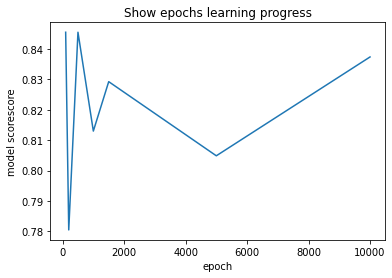

In [42]:
plt.title("Show epochs learning progress")
plt.xlabel("epoch")
plt.ylabel("model scorescore")
plt.plot(epochs, model_scores)
plt.show()

## Linear SVC

In [43]:
SVCpipe = Pipeline([#('scale', StandardScaler()),
                   ('SVC',LinearSVC(max_iter = 10000))])

# check StandardScaler? 
param_grid = {'SVC__C':np.arange(0.01,100,3),
               'SVC__tol': [1e-3, 1e-4, 1e-2],   # stopping criterion
               'SVC__loss': ['hinge', 'squared_hinge'] } # np.arange(0.01,100,20)
linearSVC = RandomizedSearchCV(SVCpipe,param_grid,return_train_score=True, n_jobs = 6, verbose = 10, n_iter=10, scoring='accuracy', cv=3)

In [44]:
np.arange(0.001,100,3)

array([1.0000e-03, 3.0010e+00, 6.0010e+00, 9.0010e+00, 1.2001e+01,
       1.5001e+01, 1.8001e+01, 2.1001e+01, 2.4001e+01, 2.7001e+01,
       3.0001e+01, 3.3001e+01, 3.6001e+01, 3.9001e+01, 4.2001e+01,
       4.5001e+01, 4.8001e+01, 5.1001e+01, 5.4001e+01, 5.7001e+01,
       6.0001e+01, 6.3001e+01, 6.6001e+01, 6.9001e+01, 7.2001e+01,
       7.5001e+01, 7.8001e+01, 8.1001e+01, 8.4001e+01, 8.7001e+01,
       9.0001e+01, 9.3001e+01, 9.6001e+01, 9.9001e+01])

In [45]:
linearSVC.fit(X_train,y_train)
print(linearSVC.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'SVC__tol': 0.01, 'SVC__loss': 'squared_hinge', 'SVC__C': 54.01}


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [46]:
print(linearSVC.best_params_)

{'SVC__tol': 0.01, 'SVC__loss': 'squared_hinge', 'SVC__C': 54.01}


In [47]:
model_LinearSVC = LinearSVC(max_iter = 10000, C = 81.01, tol = 0.0001, loss = 'squared_hinge')


In [48]:
model_LinearSVC.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=81.01, max_iter=10000)

In [49]:
model_LinearSVC.fit(X_train, y_train)        
preds_svc = model_LinearSVC.predict(X_test)

print('accuracy_score : ', accuracy_score(y_test, preds_svc), ' precision_score : ' , precision_score(y_test, preds_svc, average='binary'), ' recall_score: ', recall_score(y_test, preds_svc, average='binary'))

accuracy_score :  0.8455284552845529  precision_score :  0.9285714285714286  recall_score:  0.41935483870967744


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Dense Neural Network

In [50]:
model_nn = Sequential()
model_nn.add(tf.keras.Input(shape=(23,)))
model_nn.add(BatchNormalization())
model_nn.add(tf.keras.layers.Dense(100, activation='relu'))
model_nn.add(tf.keras.layers.Dense(200, activation='relu'))
model_nn.add(tf.keras.layers.Dense(300, activation='relu'))
model_nn.add(tf.keras.layers.Dense(400, activation='relu'))
model_nn.add(tf.keras.layers.Dense(500, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [51]:
safety = EarlyStopping(patience = 3, monitor='val_loss')

In [52]:

model_nn.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy() , metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

# optimizer : sgd, adam
# loss : tf.keras.losses.BinaryCrossentropy(), mean_squared_error

In [53]:
history = model_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=200, callbacks=[safety])

Epoch 1/1000
3/3 [==============================] - 3s 414ms/step - loss: 0.7240 - accuracy: 0.5153 - false_negatives: 79.0000 - false_positives: 159.0000 - auc: 0.5446 - precision: 0.3402 - recall: 0.5093 - val_loss: 0.6756 - val_accuracy: 0.7480 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.7162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.6070 - accuracy: 0.6762 - false_negatives: 58.0000 - false_positives: 101.0000 - auc: 0.7297 - precision: 0.5049 - recall: 0.6398 - val_loss: 0.6723 - val_accuracy: 0.7480 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.7291 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.5571 - accuracy: 0.7454 - false_negatives: 52.0000 - false_positives: 73.0000 - auc: 0.7952 - precision: 0.5989 - recall: 0.6770 - val_loss: 0.6701 - val_accu

dict_keys(['loss', 'accuracy', 'false_negatives', 'false_positives', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_false_negatives', 'val_false_positives', 'val_auc', 'val_precision', 'val_recall'])


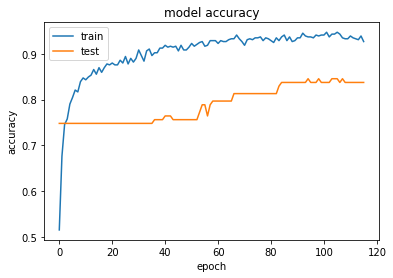

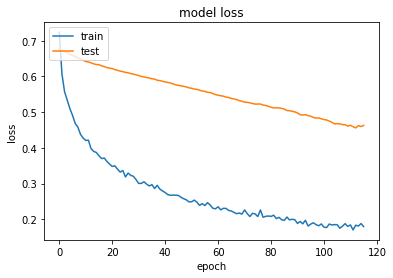

In [54]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
nn_preds = model_nn.predict(X_test)

4/4 [==============================] - 0s 4ms/step


In [56]:
test_guess_nn = pd.DataFrame(nn_preds)
test_guess_nn['predict'] = 0
test_guess_nn.loc[test_guess_nn[0]>0.5,"predict"]=1

In [57]:
precision = precision_score(test_guess_nn['predict'],y_test)
recall = recall_score(test_guess_nn['predict'],y_test)
accuracy = accuracy_score(test_guess_nn['predict'],y_test)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5}")

Accuracy: 0.83740
Precision: 0.41935
Recall: 0.86667


# Final Predictions

In [63]:
test = pd.read_csv("/content/drive/MyDrive/Job Search/UMortgage/test.csv")


#### Prep Prediction Data

In [64]:
# Missing Values - fill with modes and medians of train set (keep consistent because models are based off this)

# Dataset 1: Imputation - all less than 10%
test_impute = test.copy()

# Mode
test_impute['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test_impute['Married'].fillna(train['Married'].mode()[0], inplace=True)
test_impute['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
test_impute['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

# New Category - Missing
test_impute['Self_Employed'].fillna('Missing', inplace=True)
test_impute['Credit_History'].fillna('Missing', inplace=True)

# Median
test_impute['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

# Dataset 2: Throwing Out Missing Rows 
test_drop = test.dropna(how='any')

# Check if missing values are gone in both datasets
print(test.isnull().sum())
print(test_impute.isnull().sum())
print(test_drop.isnull().sum())
print(test_drop.shape)

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64
(289, 12)


In [65]:
# Changing Column Types
test_revise = test_impute.copy()

test_revise = test_revise.drop("Loan_ID", axis=1) # Dropping because only unique values per row

test_revise['ApplicantIncome'] = test_revise['ApplicantIncome'].astype('float') # Make consistent with other numeric variables

# test_revise['Loan_Amount_Term'] = test_revise['Loan_Amount_Term'].astype('object')
test_revise['Credit_History'] = test_revise['Credit_History'].astype('object')

test_revise.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History        object
Property_Area         object
dtype: object

In [66]:
# Define Numeric and Categorical Columns
num_col = [i for i in test_revise.columns if test_revise.dtypes[i]=='float']
categ_col = [i for i in test_revise.columns if test_revise.dtypes[i]=='object']

print(num_col)
print(categ_col)

['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']


In [67]:
# Standardize Numeric (based on train means and standard deviations)
test_revise['ApplicantIncome'] = (test_revise['ApplicantIncome']-mean_AppIncome_train)/std_AppIncome_train
test_revise['CoapplicantIncome'] = (test_revise['CoapplicantIncome']-mean_CoappIncome_train)/std_CoappIncome_train
test_revise['LoanAmount'] = (test_revise['LoanAmount']-mean_LoanAmnt_train)/std_LoanAmnt_train
test_revise['Loan_Amount_Term'] = (test_revise['Loan_Amount_Term']-mean_LAT_train)/std_LAT_train


numer_features = test_revise[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']]

In [68]:
# Categorical Variable One Hot Encoding
categ_features = pd.get_dummies(test_revise[categ_col])

In [69]:
# Recombine Categorical with Numeric
test_processed = pd.concat([numer_features, categ_features], axis=1)
test_processed.shape

(367, 23)

#### Run Predictions with Basic Logistic Regression Model

In [80]:
# Evaluate final model with test data
final_predictions = lr_basic.predict(test_processed)

final_predictions

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [81]:
# Target into binary: YES=0 NO=1

final_predictions = final_predictions.astype(np.str)


final_predictions[final_predictions == '0'] = 'Y' 
final_predictions[final_predictions == '1'] = 'N' 
final_predictions


<ipython-input-81-76733745f3e9>:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  final_predictions = final_predictions.astype(np.str)


array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y

In [96]:
# Add Predictions into test dataframe
final_predictions = pd.DataFrame(final_predictions)
test_with_preds = pd.concat([test, final_predictions], axis=1)

test_with_preds.columns.values[12] = 'Loan_Status'
test_with_preds.head

<bound method NDFrame.head of       Loan_ID Gender Married Dependents     Education Self_Employed  \
0    LP001015   Male     Yes          0      Graduate            No   
1    LP001022   Male     Yes          1      Graduate            No   
2    LP001031   Male     Yes          2      Graduate            No   
3    LP001035   Male     Yes          2      Graduate            No   
4    LP001051   Male      No          0  Not Graduate            No   
..        ...    ...     ...        ...           ...           ...   
362  LP002971   Male     Yes         3+  Not Graduate           Yes   
363  LP002975   Male     Yes          0      Graduate            No   
364  LP002980   Male      No          0      Graduate            No   
365  LP002986   Male     Yes          0      Graduate            No   
366  LP002989   Male      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5720                  0     

### Analysis: 
1. Analyze and explain the output of your model.

From the basic logistic regression model chosen, predictions were outputed that match the training dataset in the format of 'Y' for yes and 'N' for no. These values predict whether the test set of clients should be approved for a loan, based off the data given. finalpredictions is an array with only the Loan Status values, and test_with_preds is the entire test dataset with the addition of the Loan Status predictions added in. 

2. Why did you use that model?

Based on all the performance statistics of the above models, I chose to go with the basic logistic regression model. The majority of the models were giving almost the exact same statistics (accuracy, performance, recall). So if all models are performing the same, it's generally better to go with the less complex models. This is because they are more interpretable and easily explained and analyzed. With the logistic regression model, we can use L1 and L2 to see what features are most important, and use that to draw insights about the data. 

3. What could you do to improve your model?

If given more time, there are lots of model tuning steps that can be taken. While Random Search and Grid Searches are very useful, they tend to take time. It would be ideal to use these more exhaustive searches on each model, to find the very best parameters. 

I would also dive a bit into feature creation. Some areas that could be explored include squaring or combining the numeric features with each other, or changing around the buckets for the categorical variables. Both of these could potentially increase the performance of the models. 

For the missing values, I would also explore more complex methods of imputation to see if they improve performance. Rather than more simple methods that I used, more complex models like KNN or even Linear/Logistic Regressions could be explored. 

4. What next steps would you take to?

The next steps with this process would include taking all the improvements listed in part 2, and conducting them to see if model performance improves at all. 

Then, whatever model and features chosen can be interpreted for their other value, for example knowing that Applicant Income is one of the most important factors in whether or not a loan is approved, or other information like that. 

In order to present findings, I would create a presentation with many more visualizations, key takeaways, and easily interpretable results so they can be communicated outside of the Technology Team and actions can start to be taken off what is learned. 

